# Normalization

**Import**

In [47]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import bbknn
import diffxpy.api as dxpy
import plotly.express as px

# Meritxell's
import anndata2ri

In [10]:
# Meritxell's normalization
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


**Read anndata matrix**

In [11]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/HUM/adata/'

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_hum.h5ad'

In [12]:
# open saved data
adata = sc.read(adata_out_mm)

In [13]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [14]:
pwd

'/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/notebooks/norm_cluster'

In [15]:
cd '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/'

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial


In [16]:
%run Scripts/pythonScripts.py

computing PCA
    with n_comps=50
    finished (0:00:23)


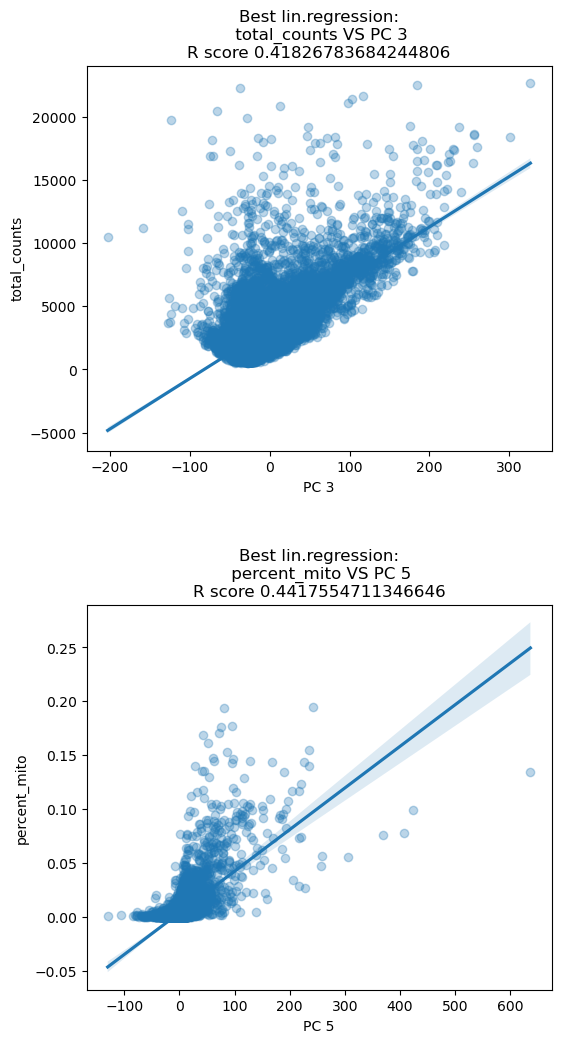

In [17]:
#from /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/Scripts/pythonScripts import dependentFeatures

#PCA on unnormalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito']) # plots the PC with the highest R2 to total counts and percent mito, respectively


The third biggest variation in the data at this point is explained by total UMI count. Normalizing with TPM should remove this bias.

In [46]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [19]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [20]:
rawMatrix.shape

(28403, 14822)

In [21]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset)  # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # normalize data with Negative binomial regression
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") # assign normalized and scaled data
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts")
genes_var <- rownames(seurat_df$SCT)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



[1] 28403 14822


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 28403 by 14822

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 34 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 28403 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 28403 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.305916 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                        

In [22]:
norm_sct.shape

(28403, 14822)

In [23]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [24]:
# remove objects from R workspace that I will no longer need
# %%R
# rm(list = ls())

In [25]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change _ in gene names to - so it works in R code
adata = adata[:,np.array(genes_var)].copy() # only use genes ...
# creating SCT layers in anndata object
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

In [26]:
adata.X = adata.layers['norm_sct'].copy() # normalized and scaled matrix as default

In [27]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:45)


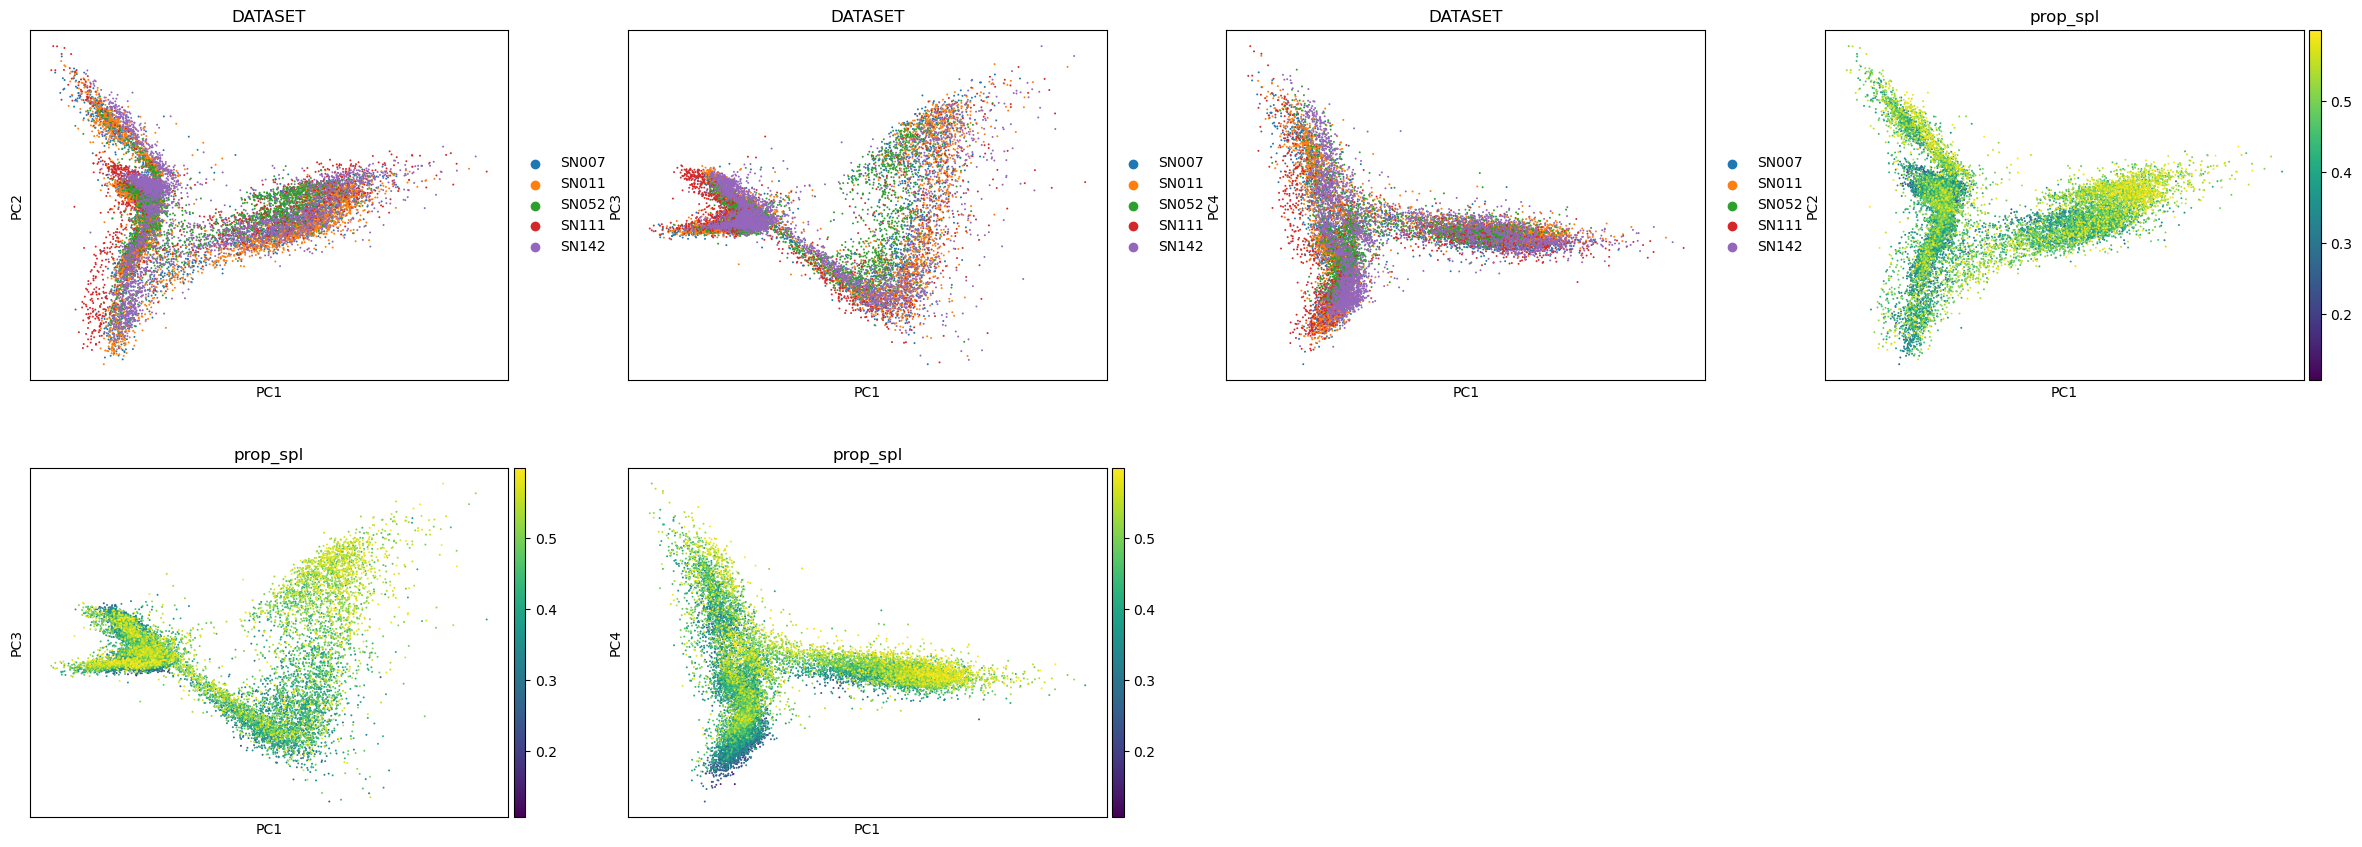

In [28]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

In [29]:
# most variable genes, True or False
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:22)


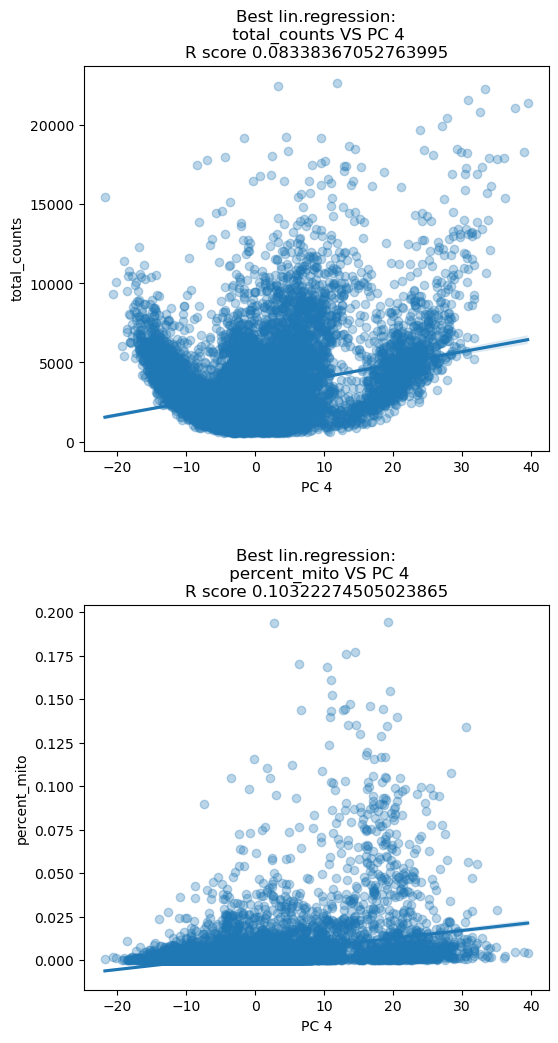

In [30]:
#PCA on normalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito'])

Now the correlation isn't strong.

Luckily the samples overlap, so they can be analyzed combined

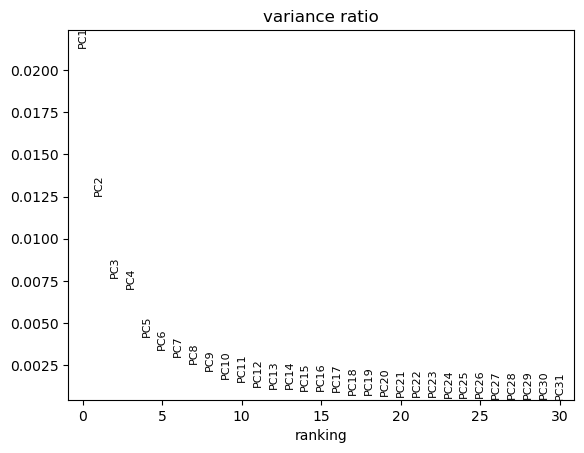

In [31]:
sc.plotting.pca_variance_ratio(adata) # small variance means it probably models noice in the data

Keep the PCs with the most variance, e.g. up to PC10

In [32]:
#sc.pp.neighbors(adata, n_pcs=15, random_state=12345) # use only for data with one single sample
bbknn.bbknn(adata, batch_key='DATASET', n_pcs=10)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [33]:
sc.tools.umap(adata, random_state=54321)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


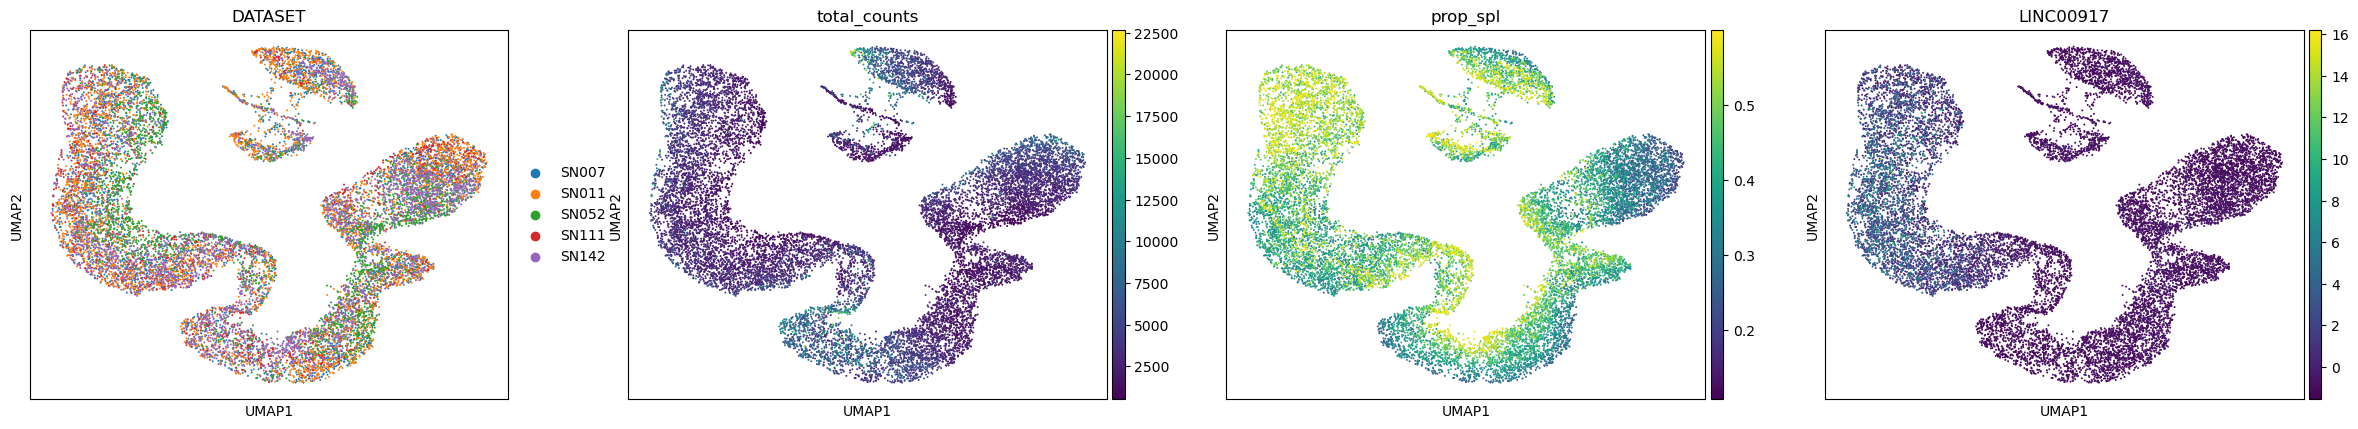

In [49]:
sc.plotting.umap(adata, color=['DATASET','total_counts','prop_spl','LINC00917'])

In [48]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [36]:
markers = dict() #make an empty dictionary
# Markers from the group google doc added
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1','PIWIL4','UTF1','SLC22A2','FGFR3']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8','ANP32B','SDF2L1','DMRT1','NANOS3'] # add markers for both?
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101','SPAG6','FTHL17','ART3','KCTD19','ASRGL1','LDHAL6B','LYAR','ZPBP2','ADAM2','CLGN','DDX25'] # general 'MYBL1','SYCP3','HORMAD1','SYNGR4', missing a few pachytene markers
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN','UBE2T']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1','DNAJB13','EFHB','LYZL6','PSD3','SLC16A7','TBC1D21','TMEM144'] # missing a few markers
markers['Elong.Spt'] = ['PRM1','PRM2','AGPAT2','AKAP1','BAG1','CST8','DNAJB7','DNAJB8','FNDC8','LELP1','RANGAP1','SPATA3','TSSK6','TXNDC2','TNP1','TP53TG5']
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL','VIM','ACSL4','WT1','GAS6','BCAR1','DMRT1']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['ACTA2','CFD','IGF1','IGFBP5','CYP19A1','CYP17A1','INSL3']
markers['Endothelial'] = ['CD34']

In [37]:
# higher marker scores when only a few is considered and therefore more visible clusters
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']

In [43]:
# markers in article and course mixed
markers = dict() #make an empty dictionary
#markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['ID4','HMGA1']
markers['Dif. SG'] = ['MKI67','DMRT1','STRA8'] 
markers['SC.I'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SC.II'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct #better than tutorial
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct #better than tutorial
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids #better than tutorial
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct #better than tutorial
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [50]:
markers_scores, adata = marker_score(markers, adata)

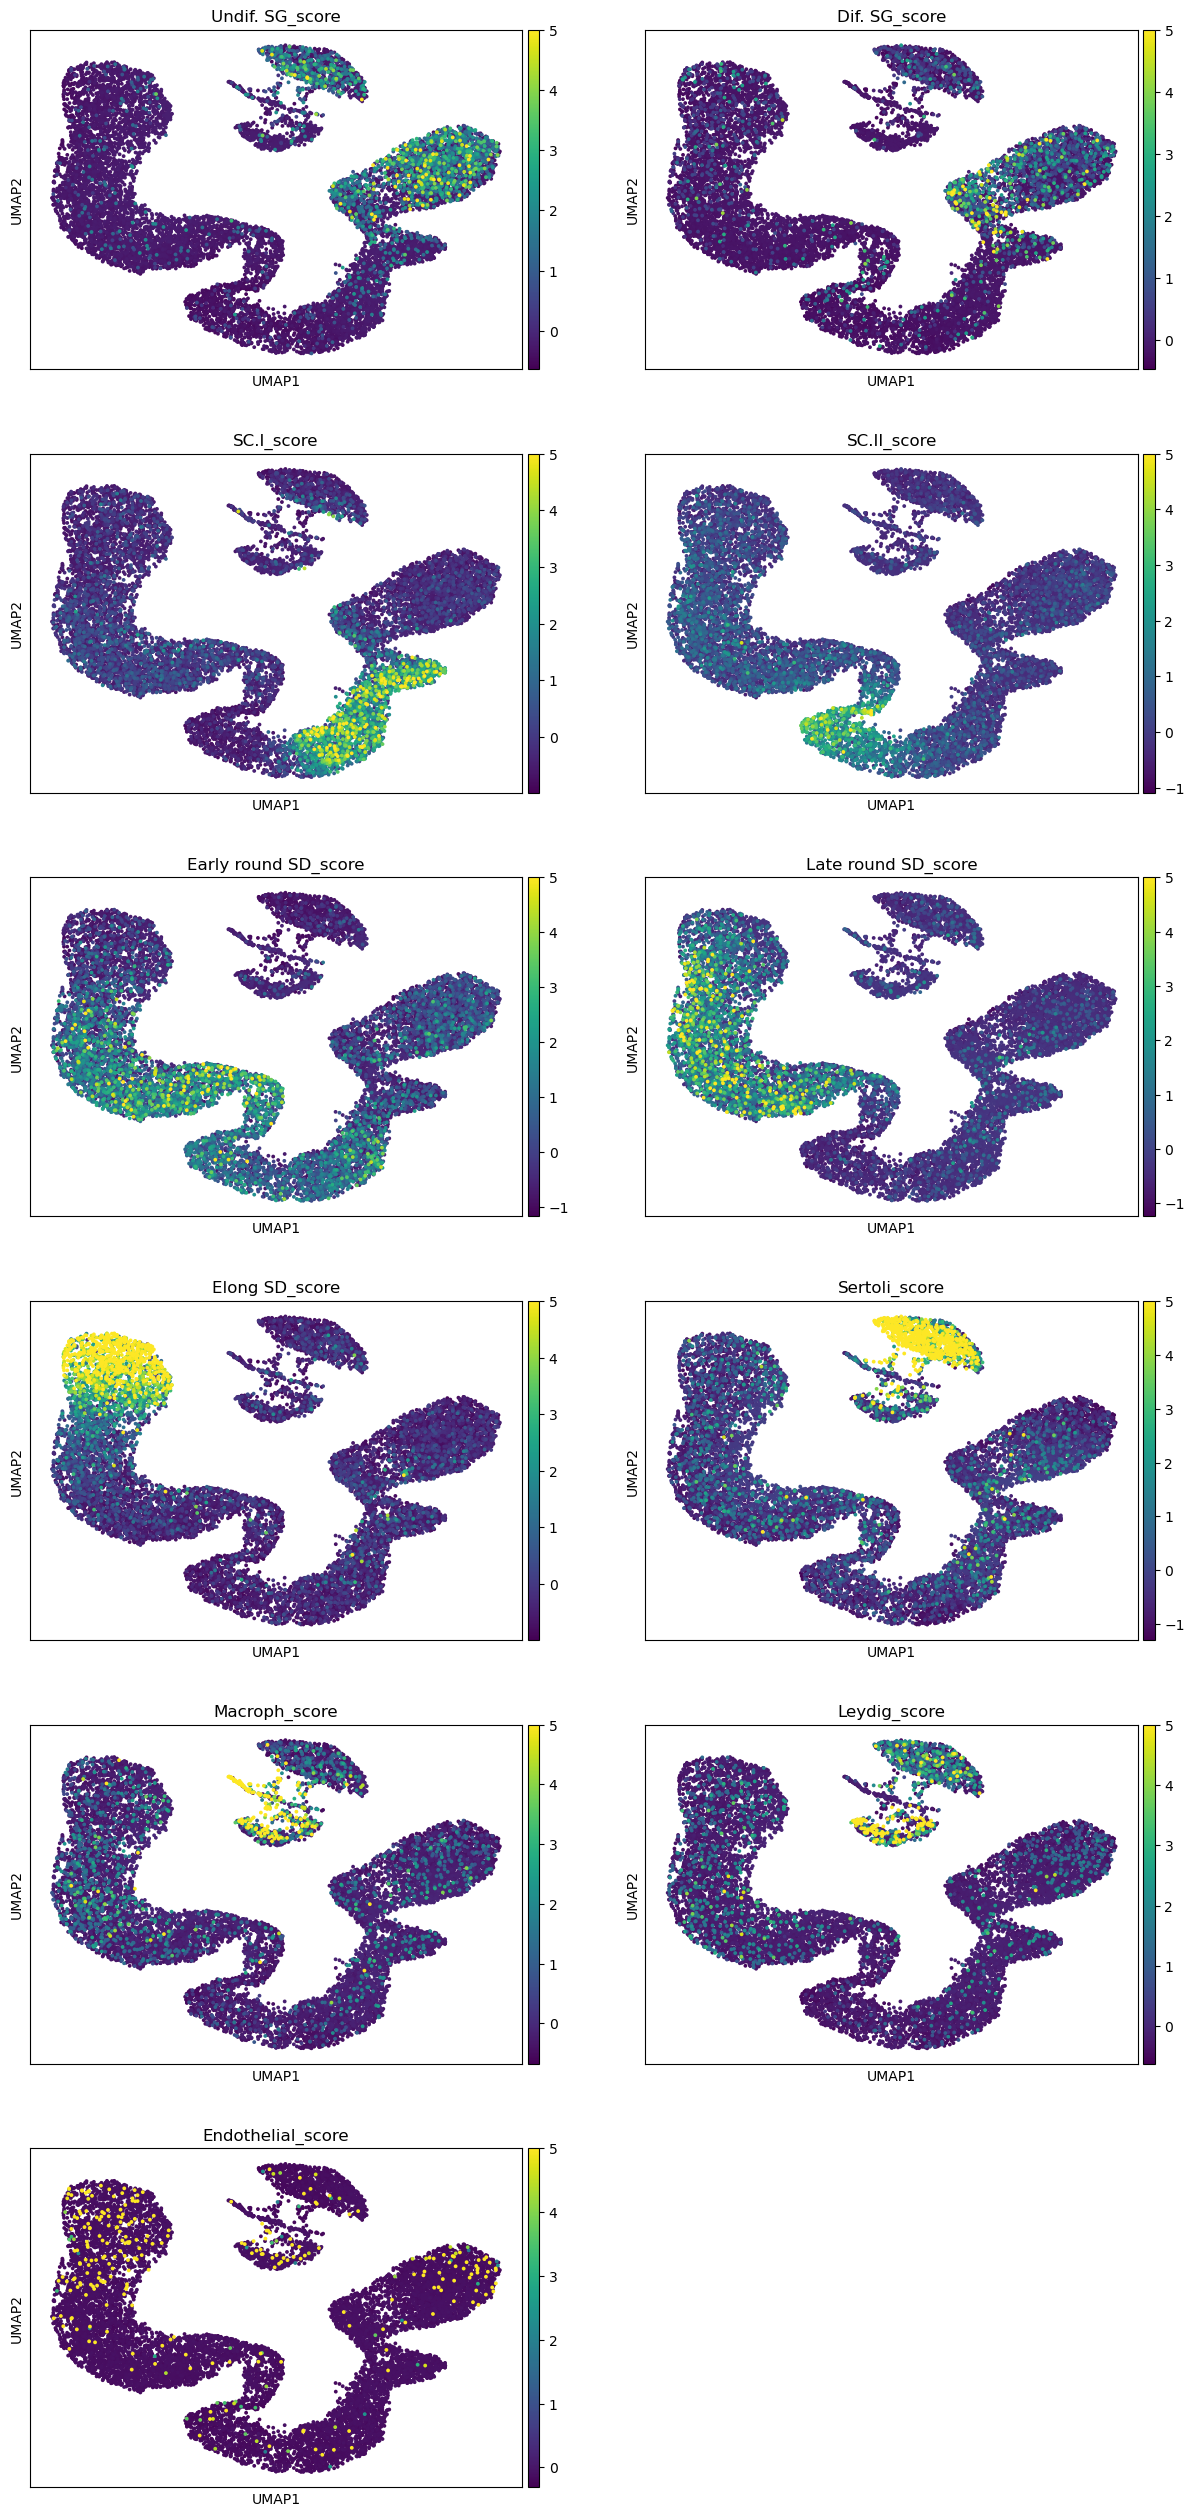

In [51]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

In [1]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/CHIMP/cluster_adata.h5ad'
adata = sc.read(saved_adata)

NameError: name 'sc' is not defined

In [52]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=0.4, random_state=12345, key_added='leiden_R.4')
sc.tools.leiden(adata, resolution=0.3, random_state=12345, key_added='leiden_R.3')
sc.tools.leiden(adata, resolution=0.2, random_state=12345, key_added='leiden_R.2')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_R.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_R.3', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_R.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_R.1', the cluster labels (adata.obs, categorical) (0:00:01)


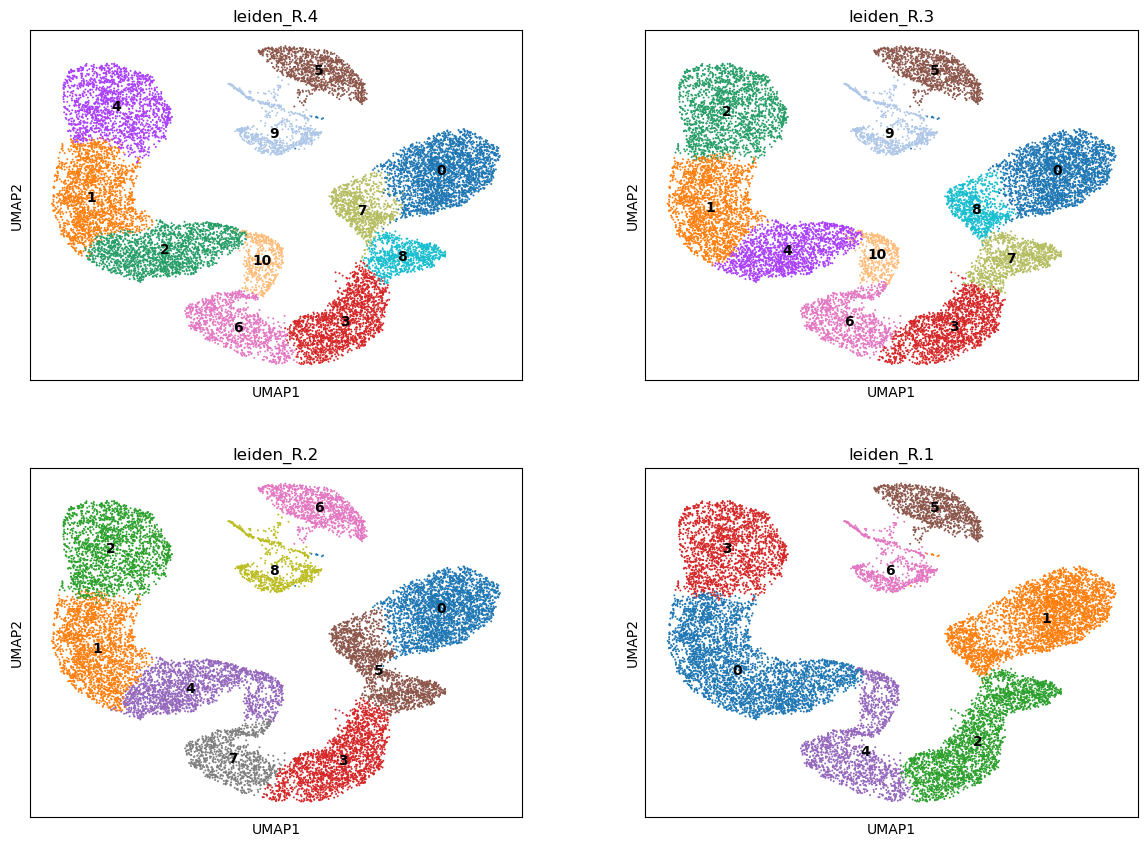

In [53]:
sc.plotting.umap(adata, color=['leiden_R.4','leiden_R.3','leiden_R.2','leiden_R.1'], legend_loc='on data', ncols=2)

In [55]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

Comparing the Leiden clusters to the clusters represented by cell markers resolution 0,3 match the best

In [56]:
sc.tl.rank_genes_groups(adata, groupby='leiden_R.3', n_genes=50, key_added='DE_leiden') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


In [57]:
adata.uns['DE_leiden']

{'params': {'groupby': 'leiden_R.3',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('MTUS2', 'LINC00917', 'PRM2', 'CCDC144A', 'CNBD1', 'GPC5', 'ANKRD20A4-ANKRD20A20P', 'AUTS2', 'AUTS2', 'MALAT1', 'SPINK2'),
            ('CALN1', 'CCDC91', 'HMGB4', 'DPY19L2', 'NLRP1', 'SYNE2', 'DPY19L2', 'RIMS2', 'PTMA', 'NEAT1', 'COX7A2'),
            ('PARD3', 'FAM186A', 'PRM1', 'ANKRD62', 'LRBA', 'ERBB4', 'STRBP', 'AGBL4', 'amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'RBMS3', 'RBAKDN'),
            ('NLGN1', 'LINC01492', 'SCP2D1', 'ANKRD30A', 'PSD3', 'ZBTB20', 'ANKRD30B', 'amplicon-chrX-VCX/2/3A/3B', 'SMYD3', 'IGFBP7', 'RBAK-RBAKDN'),
            ('LTBP1', 'MGAT4C', 'DNAJB7', 'LOC100506207', 'TSBP1', 'CADM1', 'ANKRD20A1', 'SMC1B', 'CALN1', 'B2M', 'COX6C'),
            ('GRIP1', 'GOLGA6L7', 'TNP1', 'SETX', 'IQCM', 'MTRNR2L8', 'C1QTNF3', 'SDK1', 'amplicon-chrX-SSX1/2/2B/344B/5/7', 'FTL', 

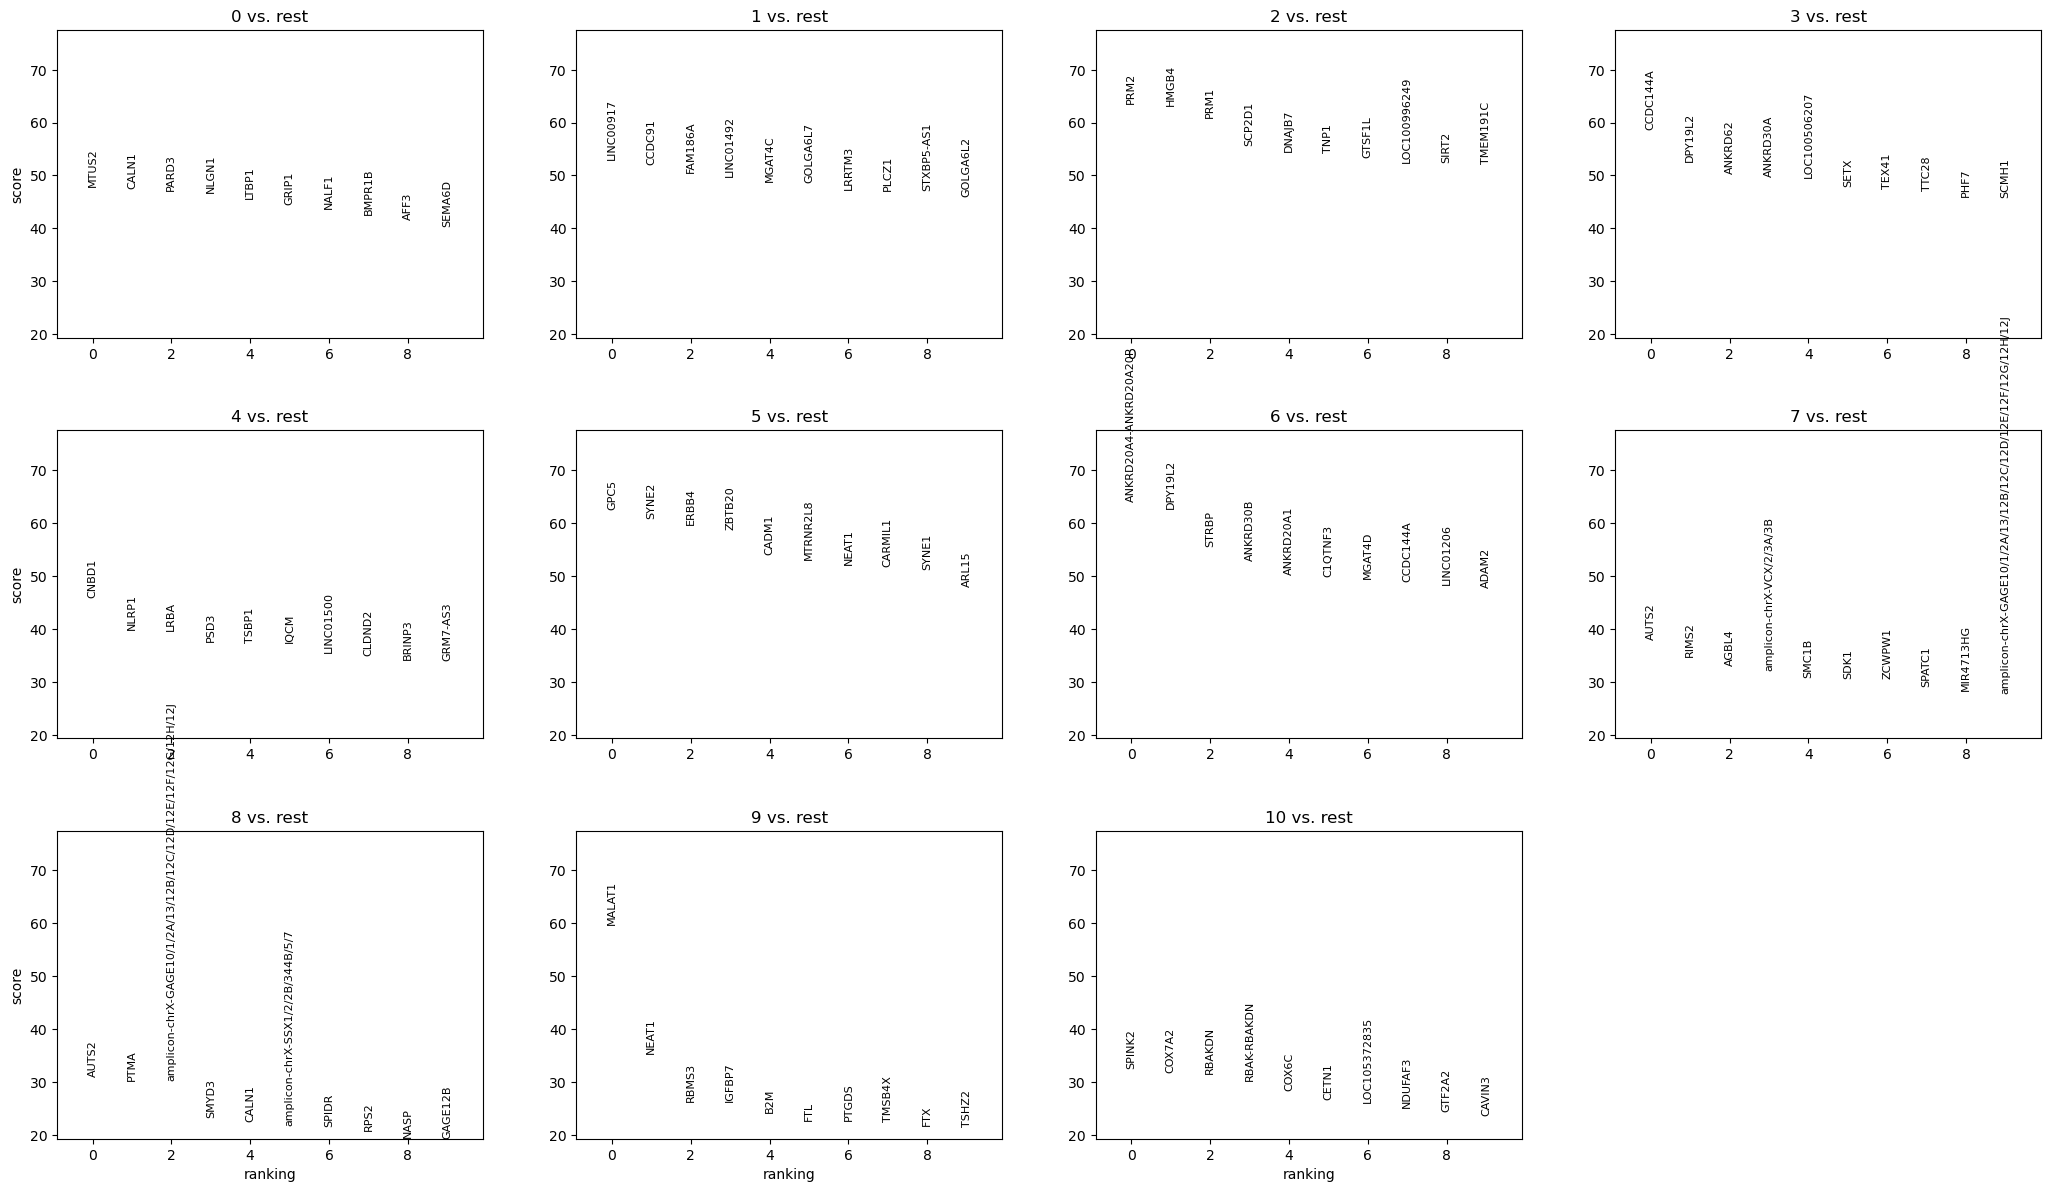

In [58]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='leiden_R.3', key='DE_leiden') # sharey=False to change y axis to individual score

In [59]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'DE_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [5]:
adata.var['means']

MIR1302-2HG      6.648561
FAM138A         13.548458
LOC100996442     2.960305
LOC729737        9.884073
LOC107985721    13.630867
                  ...    
ND4L            14.237533
ND4             16.590565
ND5             13.723933
ND6             14.079049
CYTB            16.968060
Name: means, Length: 28437, dtype: float64

In [7]:
adata.var['dispersions']

MIR1302-2HG     15.710300
FAM138A         22.479639
LOC100996442    11.973879
LOC729737       19.046465
LOC107985721    22.558533
                  ...    
ND4L            22.079511
ND4             21.457957
ND5             21.854305
ND6             22.416355
CYTB            21.485773
Name: dispersions, Length: 28437, dtype: float64

In [8]:
adata.var['dispersions_norm']

MIR1302-2HG     0.401666
FAM138A         1.066865
LOC100996442    1.210462
LOC729737      -0.313558
LOC107985721    1.548448
                  ...   
ND4L           -2.606271
ND4            -2.934455
ND5            -2.750251
ND6             0.680574
CYTB           -0.892014
Name: dispersions_norm, Length: 28437, dtype: float32

Organize result in a table. Each column has the cluster numbers with _N, _P representing respectively the gene Names, their P-values and the Log-fold change of each gene expression compared to the other clusters.

In [60]:
result = adata.uns['DE_leiden']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})
X.head() #print only first five lines

0_N  0_P        1_N  1_P     2_N  2_P           3_N  3_P    4_N  \
0  MTUS2  0.0  LINC00917  0.0    PRM2  0.0      CCDC144A  0.0  CNBD1   
1  CALN1  0.0     CCDC91  0.0   HMGB4  0.0       DPY19L2  0.0  NLRP1   
2  PARD3  0.0    FAM186A  0.0    PRM1  0.0       ANKRD62  0.0   LRBA   
3  NLGN1  0.0  LINC01492  0.0  SCP2D1  0.0      ANKRD30A  0.0   PSD3   
4  LTBP1  0.0     MGAT4C  0.0  DNAJB7  0.0  LOC100506207  0.0  TSBP1   

             4_P  ...                    6_N            6_P  \
0  2.691747e-297  ...  ANKRD20A4-ANKRD20A20P   0.000000e+00   
1  1.323192e-240  ...                DPY19L2   0.000000e+00   
2  2.429917e-244  ...                  STRBP  3.685343e-310   
3  1.656203e-225  ...               ANKRD30B  1.309036e-291   
4  3.542946e-222  ...              ANKRD20A1  7.476577e-276   

                         7_N            7_P  \
0                      AUTS2  6.607402e-195   
1                      RIMS2  7.724433e-173   
2                      AGBL4  3.854366e-161   
3  amplicon-chrX-VCX/2/3A/3B  2.341795e-154   
4                      SMC1B  2.856733e-145   

                                                 8_N            8_P     9_N  \
0                                              AUTS2  2.056431e-141  MALAT1   
1                                               PTMA  1.375312e-135   NEAT1   
2  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  2.384024e-135   RBMS3   
3                                              SMYD3   1.767062e-92  IGFBP7   
4                                              CALN1   3.280149e-87     B2M   

             9_P         10_N           10_P  
0  2.247045e-279       SPINK2  2.967646e-115  
1  2.675848e-157       COX7A2  3.493145e-112  
2  8.104188e-106       RBAKDN  2.574382e-111  
3  4.516460e-105  RBAK-RBAKDN  6.126335e-106  
4   3.835152e-93        COX6C   3.913265e-98  

[5 rows x 22 columns]

In [61]:
pd.DataFrame(adata.uns['DE_leiden']['names']).head() # top 5 ranked genes for each cluster

0          1       2             3      4       5  \
0  MTUS2  LINC00917    PRM2      CCDC144A  CNBD1    GPC5   
1  CALN1     CCDC91   HMGB4       DPY19L2  NLRP1   SYNE2   
2  PARD3    FAM186A    PRM1       ANKRD62   LRBA   ERBB4   
3  NLGN1  LINC01492  SCP2D1      ANKRD30A   PSD3  ZBTB20   
4  LTBP1     MGAT4C  DNAJB7  LOC100506207  TSBP1   CADM1   

                       6                          7  \
0  ANKRD20A4-ANKRD20A20P                      AUTS2   
1                DPY19L2                      RIMS2   
2                  STRBP                      AGBL4   
3               ANKRD30B  amplicon-chrX-VCX/2/3A/3B   
4              ANKRD20A1                      SMC1B   

                                                   8       9           10  
0                                              AUTS2  MALAT1       SPINK2  
1                                               PTMA   NEAT1       COX7A2  
2  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...   RBMS3       RBAKDN  
3                                              SMYD3  IGFBP7  RBAK-RBAKDN  
4                                              CALN1     B2M        COX6C

In [62]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [53]:
!mkdir -p cluster_results/HUM

In [63]:
X.to_csv('cluster_results/HUM/expr_annotation.csv', sep=',', index=None)

In [65]:
# cell type names for the chosen clusters

#new_names = {
#    '0':'SpermatogoniaA.1',
#    '1':'SpermatogoniaA.2',
#    '2':'Myoid',
#    '3':'Endothelial',
#    '4':'Leydig',
#    '5':'SpermatogoniaB',
#    '6':'Elong_Spermatids',
#    '7':'SpermatocitesII.1',
#    '8':'SpermatocitesII.2',
#    '9':'Round_Spermatids',
#    '10':'SpermatocitesI',
#    '11':'Macroph',
#    '12':'Pericytes'}


new_names = {
    '0':'Undif. SG',
    '1':'Late round SD',
    '2':'Elong. SD',
    '3':'SC.I',
    '4':'Early round SD',
    '5':'Sertoli',
    '6':'SC.II',
    '7':'SC.I',
    '8':'Dif. SG',
    '9':'Macrophage',
    '10':'Early round SD'
}


We merge the clusters with same names. This cannot be done with a categorical object, where categories cannot have the same name. We convert the cluster names into a simple array to do this, and then reconvert it to a categorical object.

In [66]:
adata.obs['spermatogenesis_types'] = [new_names[x] for x in adata.obs['leiden_R.3'].tolist()]

In [67]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong. SD':'red','Sertoli':'pink','Macrophage':'brown'}

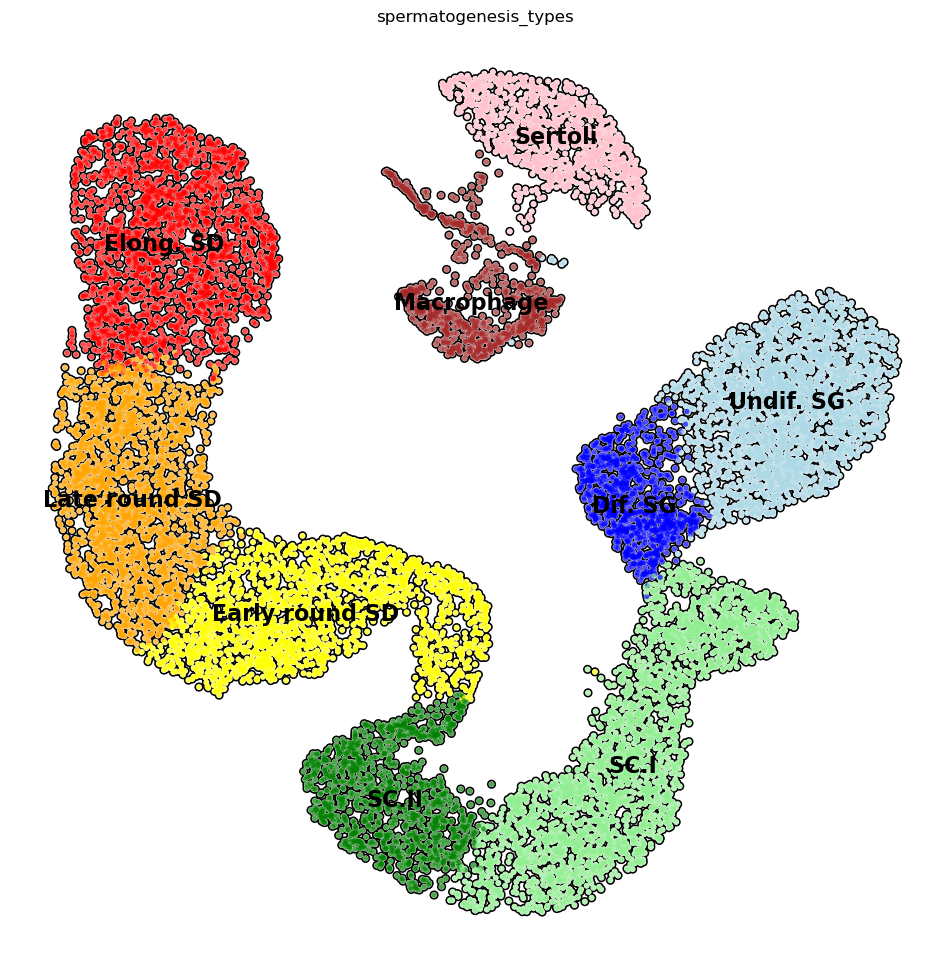

In [68]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'], 
           palette=palette_dict,
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [4]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/HUM/cluster_adata.h5ad'
adata = sc.read(saved_adata)

In [69]:
adata

AnnData object with n_obs × n_vars = 14822 × 28403
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'DE_leiden', 'spermatogenesis_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [70]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_leiden_celltype') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden_celltype']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


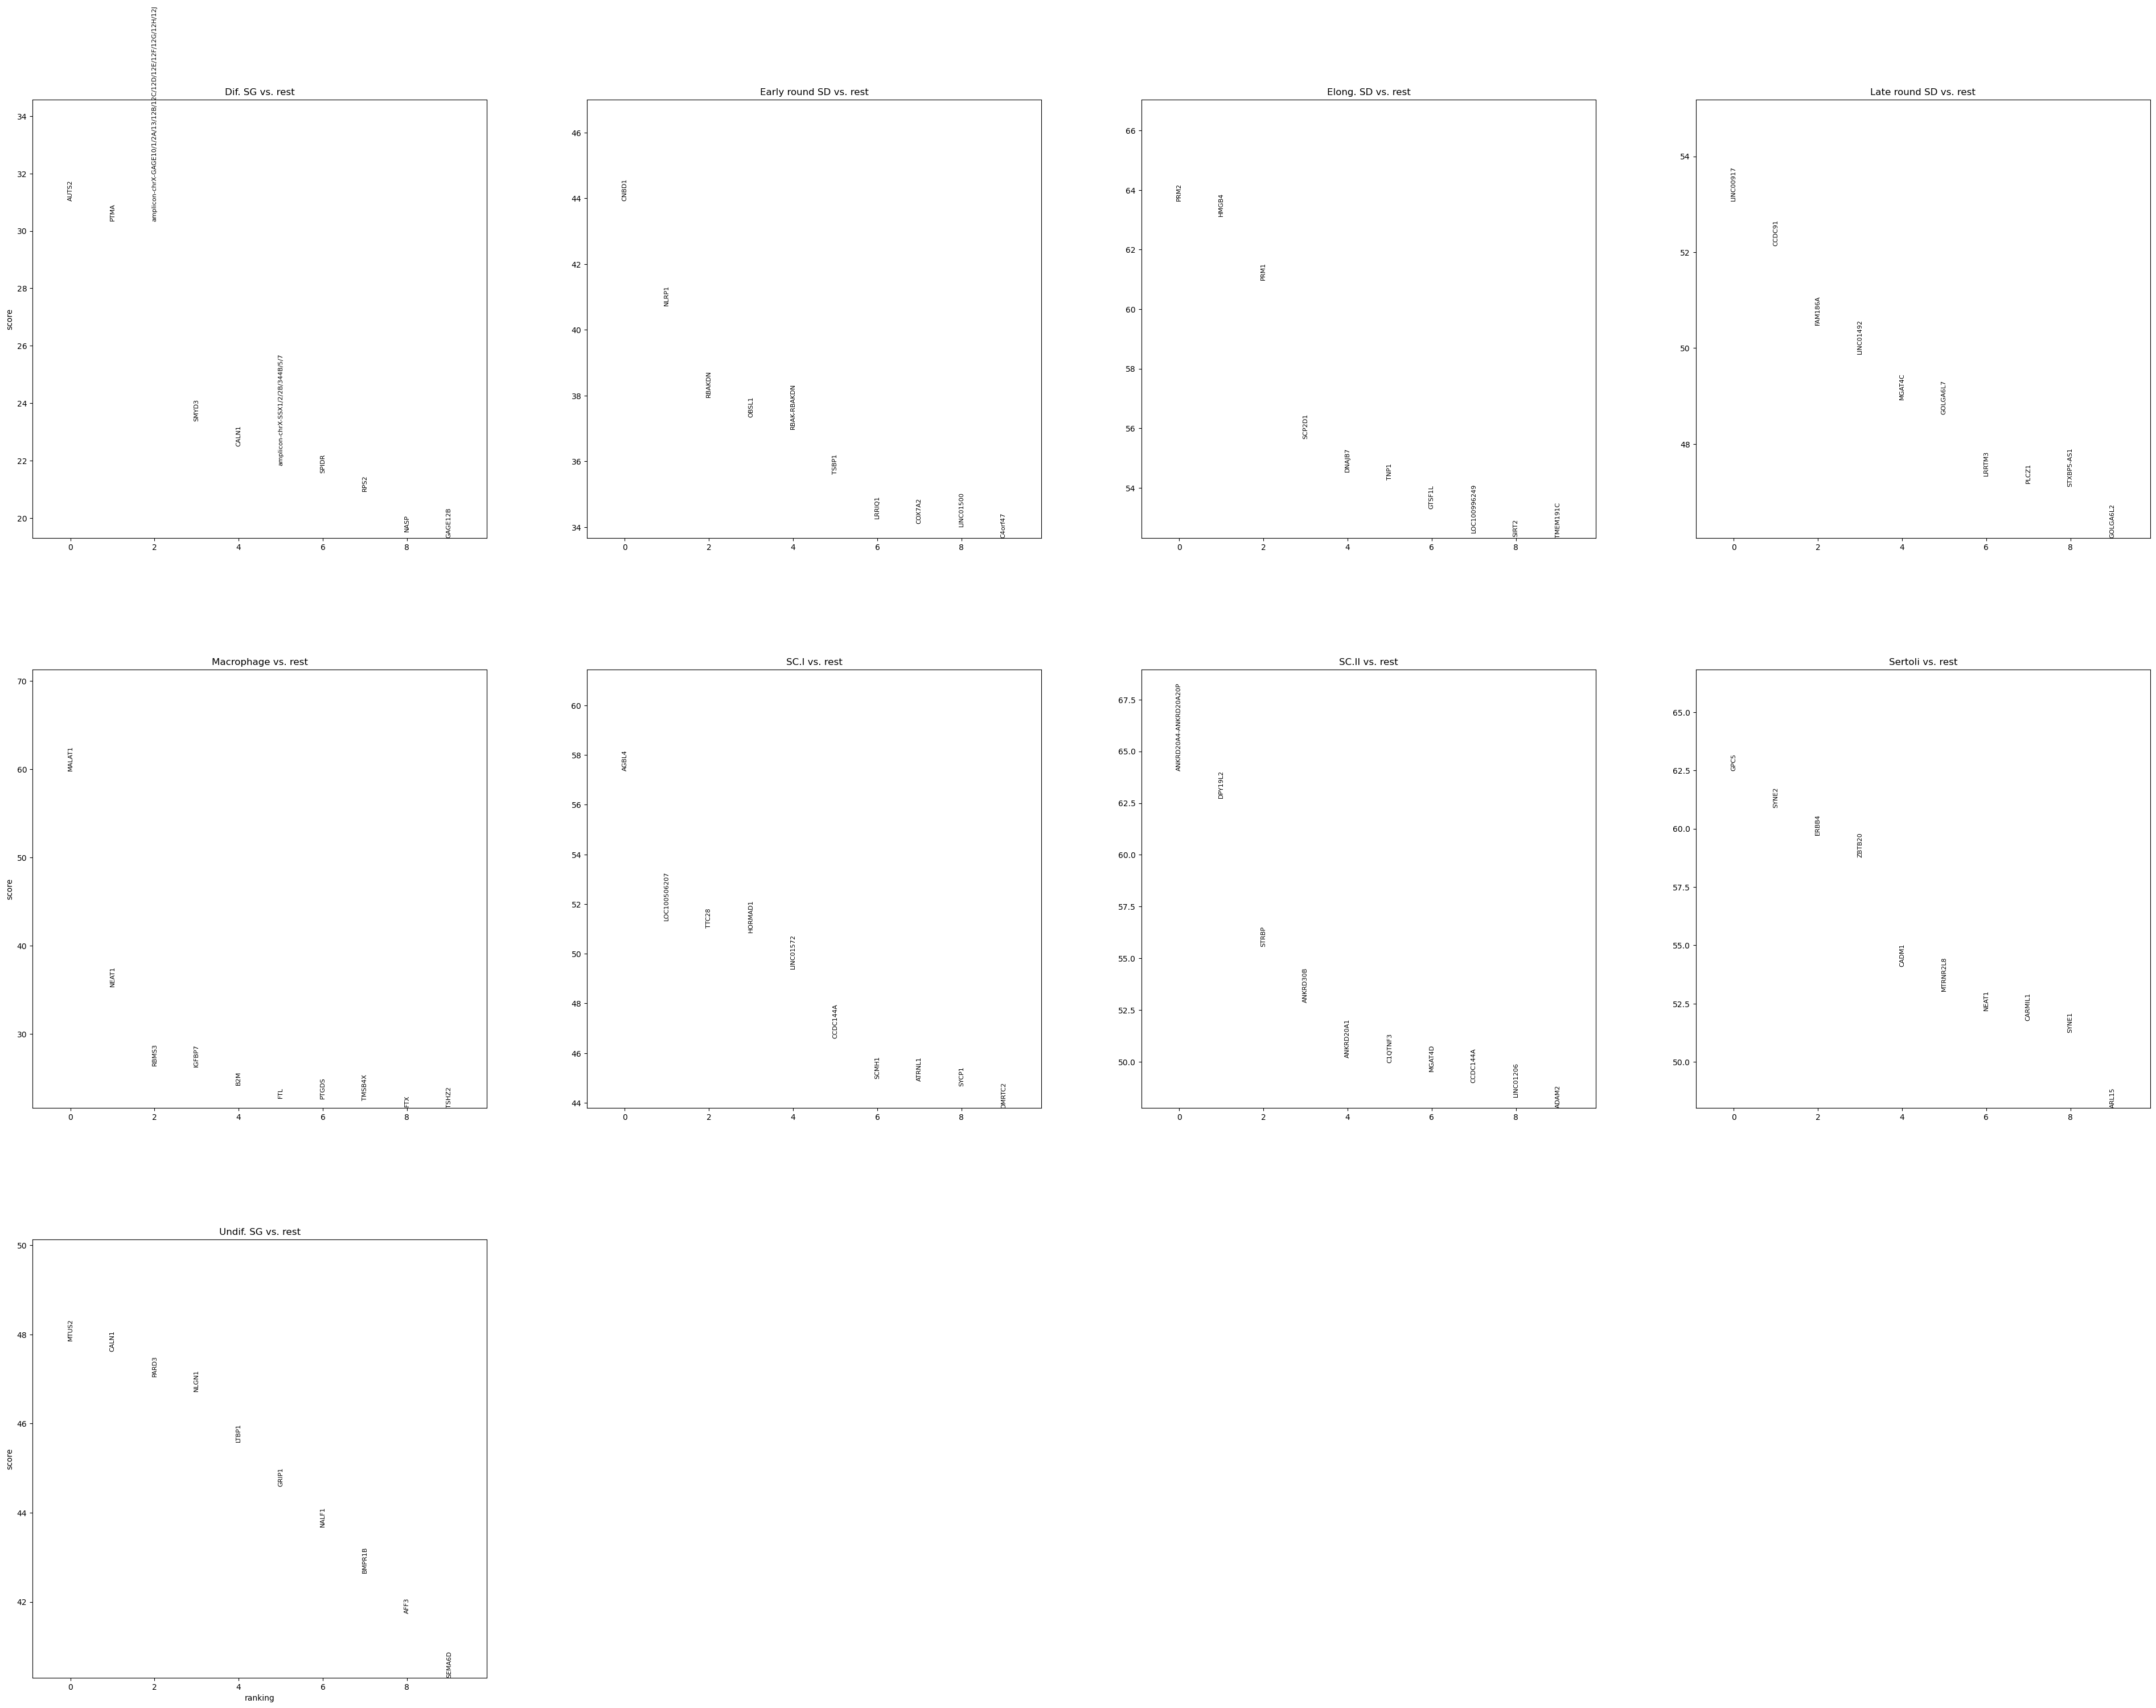

In [71]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='spermatogenesis_types', key='DE_leiden_celltype', sharey=False) # sharey=False to change y axis to individual score

In [72]:
result2 = adata.uns['DE_leiden_celltype']
groups2 = result2['names'].dtype.names
X2 = pd.DataFrame(
    {group + '_' + key[:1].upper(): result2[key][group]
    for group in groups2 for key in ['names', 'pvals_adj']})
X2.head() #print only first five lines

Dif. SG_N      Dif. SG_P  \
0                                              AUTS2  2.056431e-141   
1                                               PTMA  1.375312e-135   
2  amplicon-chrX-GAGE10/1/2A/13/12B/12C/12D/12E/1...  2.384024e-135   
3                                              SMYD3   1.767062e-92   
4                                              CALN1   3.280149e-87   

  Early round SD_N  Early round SD_P Elong. SD_N  Elong. SD_P Late round SD_N  \
0            CNBD1     2.438843e-299        PRM2          0.0       LINC00917   
1            NLRP1     1.802107e-264       HMGB4          0.0          CCDC91   
2           RBAKDN     1.500012e-240        PRM1          0.0         FAM186A   
3            OBSL1     6.116518e-234      SCP2D1          0.0       LINC01492   
4      RBAK-RBAKDN     7.627535e-231      DNAJB7          0.0          MGAT4C   

   Late round SD_P Macrophage_N   Macrophage_P        SC.I_N  SC.I_P  \
0              0.0       MALAT1  2.247045e-279         AGBL4     0.0   
1              0.0        NEAT1  2.675848e-157  LOC100506207     0.0   
2              0.0        RBMS3  8.104188e-106         TTC28     0.0   
3              0.0       IGFBP7  4.516460e-105       HORMAD1     0.0   
4              0.0          B2M   3.835152e-93     LINC01572     0.0   

                 SC.II_N        SC.II_P Sertoli_N      Sertoli_P Undif. SG_N  \
0  ANKRD20A4-ANKRD20A20P   0.000000e+00      GPC5   0.000000e+00       MTUS2   
1                DPY19L2   0.000000e+00     SYNE2   0.000000e+00       CALN1   
2                  STRBP  3.685343e-310     ERBB4   0.000000e+00       PARD3   
3               ANKRD30B  1.309036e-291    ZBTB20   0.000000e+00       NLGN1   
4              ANKRD20A1  7.476577e-276     CADM1  2.203135e-312       LTBP1   

   Undif. SG_P  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [73]:
X2.to_csv('cluster_results/HUM/expr_annotation_celltype.csv', sep=',', index=None)

In [74]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/HUM'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/cluster_adata.h5ad'

In [75]:
adata.write(adata_out)